# Подготовка

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from math import sqrt
from collections import defaultdict
from itertools import combinations, product, groupby
from imblearn.over_sampling import SMOTE

from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
from scipy.stats import moment, entropy, kurtosis

from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [76]:
# data generation 
N = 5
WINDOW_MIN = 8
WINDOW = 15

TRAIN_SIZE = 5000
VAL_SIZE = 200
TEST_SIZE = 200
PTS = 100

train_start = 0
train_end = TRAIN_SIZE

val_init = TRAIN_SIZE + WINDOW - 1
val_start = val_init - 1
val_end = val_start + VAL_SIZE

val_sf_init = val_end + WINDOW - 1
val_sf_start = val_sf_init - 1
val_sf_end = val_sf_start + VAL_SIZE

test_init = val_sf_end + WINDOW - 1
test_start = test_init - 1
test_end = test_start + TEST_SIZE - WINDOW 

# clusterize data
WISHART_K = 4
WISHART_H = 0.2

# generate predictions
STEPS, EPS = 50, 0.05
Q_VALUE = 0.99

In [77]:
time_series = np.loadtxt('energy_DE.txt', delimiter=',')

In [78]:
time_series.shape

(26305,)

In [79]:
time_series[:10]

array([0.25528249, 0.22101689, 0.18514104, 0.15390116, 0.14065876,
       0.12518588, 0.09115744, 0.09656993, 0.1118221 , 0.16387754])

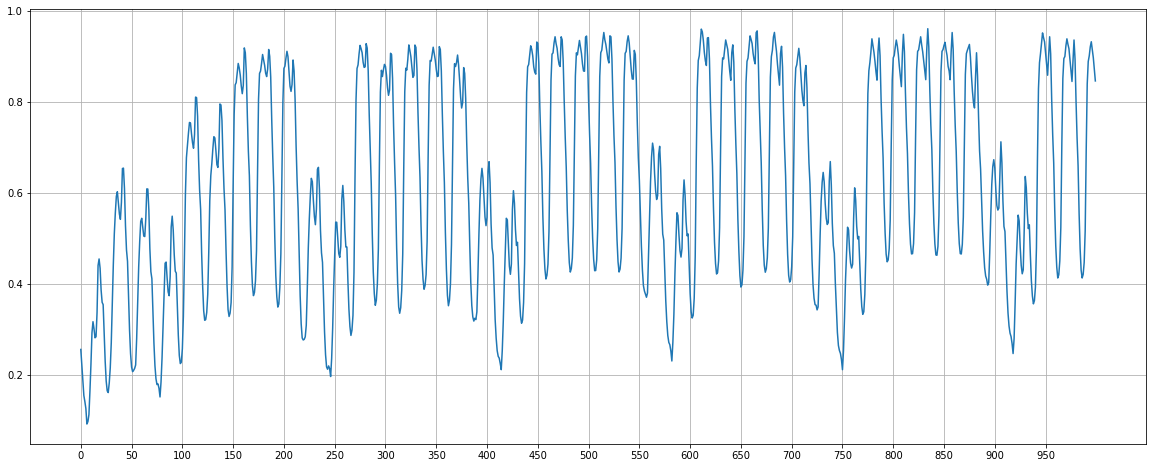

In [80]:
xs = time_series
x_train = xs[train_start:train_end]
x_val = xs[val_start:val_end]
x_val_sf = xs[val_sf_start:val_sf_end]
x_test = xs[test_start:test_end]

plt.figure(figsize=(20, 8))
plt.plot(time_series[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

# Функции

## Wishart clusterization

In [81]:
def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))
    return max_diff >= h

def partition(dist, l, r, order):
    if l == r:
        return l

    pivot = dist[order[(l + r) // 2]]
    left, right = l - 1, r + 1
    while True:
        while True:
            left += 1
            if dist[order[left]] >= pivot:
                break

        while True:
            right -= 1
            if dist[order[right]] <= pivot:
                break

        if left >= right:
            return right

        order[left], order[right] = order[right], order[left]

def nth_element(dist, order, k):
    l, r = 0, len(order) - 1
    while True:
        if l == r:
            break
        m = partition(dist, l, r, order)
        if m < k:
            l = m + 1
        elif m >= k:
            r = m

def get_clustering(x, k, h, verbose=True):
    n = len(x)
    if isinstance(x[0], list):
        m = len(x[0])
    else:
        m = 1
    dist = squareform(pdist(x))

    dk = []
    for i in range(n):
        order = list(range(n))
        nth_element(dist[i], order, k - 1)
        dk.append(dist[i][order[k - 1]])


    p = [k / (volume(dk[i], m) * n) for i in range(n)]

    w = np.full(n, 0)
    completed = {0: False}
    last = 1
    vertices = set()
    for d, i in sorted(zip(dk, range(n))):
        neigh = set()
        neigh_w = set()
        clusters = defaultdict(list)
        for j in vertices:
            if dist[i][j] <= dk[i]:
                neigh.add(j)
                neigh_w.add(w[j])
                clusters[w[j]].append(j)

        vertices.add(i)
        if len(neigh) == 0:
            w[i] = last
            completed[last] = False
            last += 1
        elif len(neigh_w) == 1:
            wj = next(iter(neigh_w))
            if completed[wj]:
                w[i] = 0
            else:
                w[i] = wj
        else:
            if all(completed[wj] for wj in neigh_w):
                w[i] = 0
                continue
            significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], h, p))
            if len(significant_clusters) > 1:
                w[i] = 0
                for wj in neigh_w:
                    if wj in significant_clusters:
                        completed[wj] = (wj != 0)
                    else:
                        for j in clusters[wj]:
                            w[j] = 0
            else:
                if len(significant_clusters) == 0:
                    s = next(iter(neigh_w))
                else:
                    s = next(iter(significant_clusters))
                w[i] = s
                for wj in neigh_w:
                    for j in clusters[wj]:
                        w[j] = s
    return w

In [82]:
class WishartClusterization(object):
    def __init__(self, k, h):
        self.k = k
        self.h = h
        
    
    def fit(self, x):
        n = len(x)
        if isinstance(x[0], list):
            m = len(x[0])
        else:
            m = 1
        dist = squareform(pdist(x))

        dk = []
        for i in range(n):
            order = list(range(n))
            nth_element(dist[i], order, self.k - 1)
            dk.append(dist[i][order[self.k - 1]])


        p = [self.k / (volume(dk[i], m) * n) for i in range(n)]

        w = np.full(n, 0)
        completed = {0: False}
        last = 1
        vertices = set()
        for d, i in sorted(zip(dk, range(n))):
            neigh = set()
            neigh_w = set()
            clusters = defaultdict(list)
            for j in vertices:
                if dist[i][j] <= dk[i]:
                    neigh.add(j)
                    neigh_w.add(w[j])
                    clusters[w[j]].append(j)

            vertices.add(i)
            if len(neigh) == 0:
                w[i] = last
                completed[last] = False
                last += 1
            elif len(neigh_w) == 1:
                wj = next(iter(neigh_w))
                if completed[wj]:
                    w[i] = 0
                else:
                    w[i] = wj
            else:
                if all(completed[wj] for wj in neigh_w):
                    w[i] = 0
                    continue
                significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], self.h, p))
                if len(significant_clusters) > 1:
                    w[i] = 0
                    for wj in neigh_w:
                        if wj in significant_clusters:
                            completed[wj] = (wj != 0)
                        else:
                            for j in clusters[wj]:
                                w[j] = 0
                else:
                    if len(significant_clusters) == 0:
                        s = next(iter(neigh_w))
                    else:
                        s = next(iter(significant_clusters))
                    w[i] = s
                    for wj in neigh_w:
                        for j in clusters[wj]:
                            w[j] = s
        self.labels_ = w
        return self

## Генерация центров кластеров

In [83]:
def generate_centers(x_trains, WISHART_K=4, WISHART_H=0.2): 
    ws = {}
    for pattern, train in x_trains.items():
        ws[pattern] = get_clustering(train, WISHART_K, WISHART_H) 
    centers = {}
    
    for pattern, w in ws.items():
        sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
        for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
            cluster = list(cluster)
            center = np.full(N, 0.0)
            for i in cluster:

                center += x_trains[pattern][i]
            centers.setdefault(pattern, []).append(center / len(cluster))

    return centers

## Генерация паттернов

In [84]:
def generate_subsequences(window, num, short=False): 
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            diff = WINDOW - WINDOW_MIN 
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result

## Подстановка паттернов

In [85]:
def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

def gen_sample_in_point(values, window, pattern, pos): 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

def gen_sample_in_point_with_q(values, window, pattern, pos): 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None
    
def generate_sample(values, window, pattern, put_none=False): 
    result = []
    for i in range(len(values)):
        res = gen_sample_in_point(values, window, pattern, i)
        if res == None:
            if put_none:
                result.append(res)
        else:
            result.append(res)
    return result

def aggr(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts)) 
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

## Функция предсказания

In [86]:
def generate_predictions(centers, deamon=None, return_set_pred=False, real_mode='test',
                          EPS=0.05, Q_VALUE=0.99):
    preds = {}
    set_preds = {}

    if real_mode == 'test':
        end_point = val_end
        init_point = test_init
    else:
        end_point = train_end
        init_point = val_init

    for start_point in tqdm(range(PTS)):
        
        # initialize empty
        preds[start_point] = [None] * (start_point + 1)
        if return_set_pred:
            set_preds[start_point] = [None] * (start_point + 1)

        # current window
        wind = list(map(lambda x: (x, 1), xs[end_point + start_point : init_point + start_point]))

        for step in range(1, STEPS + 1):
            x_tests_for_point = {}
            for pattern in patterns:
                
                key = str_subseq(pattern + (WINDOW - 1,)) 
                sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]), 
                                                    WINDOW, pattern, len(wind))
                if not sample:
                    x_tests_for_point[key] = None
                else:
                    x_tests_for_point[key] = sample

            chosen_centers = []
            for pattern, centers_values in centers.items():
                if not x_tests_for_point[pattern]:
                    continue
                vector = np.array(x_tests_for_point[pattern][:-1])[:, 0]
                q_values = np.array(x_tests_for_point[pattern][:-1])[:, 1]

                for center in centers_values:
                    dist = euclidean(vector, center[:-1])
                    if dist < EPS:
                        weight_d = (EPS - dist) / EPS
                        weight_q = np.mean(q_values) * Q_VALUE
                        chosen_centers.append((pattern, center, weight_d, weight_q))

            last_points = list(map(lambda center: (center[1][-1], center[2], center[3], center[0]), 
                                  chosen_centers))
            
            # deamon predict
            result_point = deamon.predict(start_point, step, last_points)
            preds[start_point].append(result_point)

            if return_set_pred:
                set_preds[start_point].append(last_points)

            
            if result_point:
                q_value = np.mean(np.array(list(map(lambda center: center[2], 
                                  chosen_centers))))
            else:
                q_value = None
            
            # move the window
            wind = np.concatenate([wind[1:], [(result_point, q_value)]])

    deamon.predicted = True

    if return_set_pred:
        return preds, set_preds
    return preds

## Визуализация результатов на участке ряда

In [87]:
def visualize_point(preds, point, real_vals=x_test, plot_all_points=None, plot_tube_points=None,
                    highlight_point=None, plot_res_tube=None, offset=3):
    plt.figure(figsize=(20, 8))
    colors=['green', 'red', 'orange']

    limits_real = [point - offset, point + STEPS + offset]
    plt.plot(
        range(limits_real[0], limits_real[1]),
        real_vals[limits_real[0]:limits_real[1]], 
        label='real values'
    )

    limits_predictions = [point, point + STEPS]
    for i, pred in enumerate(preds):
        plt.plot(
            range(limits_predictions[0], limits_predictions[1]),
            pred[0].get_predictions()[point][limits_predictions[0]:limits_predictions[1]], 
            label=pred[1], 
            marker='o', 
            markersize=2,
            c=colors[i]
        )

        if plot_all_points:
            for step in plot_all_points:
                raw_preds = pred[0].get_set_predictions()[point][point + step]
                set_preds = list(map(lambda x: x[0], raw_preds))
                plt.scatter([point + step for i in range(len(set_preds))], 
                            set_preds, alpha=0.2, color='red')
    if highlight_point:
        plt.plot(
            point + highlight_point,
            pred[0].get_predictions()[point][point + highlight_point], 
            label='bad', 
            marker='o', 
            markersize=10, 
            color="purple"
        )

    if plot_res_tube is not None:
        plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), plot_res_tube, label='tube avg')

    if plot_tube_points is not None:
        for tr in plot_tube_points:
            plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), tr, alpha=0.3, linestyle='--')

    

    plt.scatter([point], real_vals[point], label='start')
    plt.axvline(x=(point + 1), linewidth=0.5, color='r', label="step 1")
    for mark in range(5, STEPS + 1, 5):
        plt.axvline(x=(point + mark), linewidth=0.5, color='r', label="step " + str(mark))

    plt.title("Divergence")
    plt.xlabel("point")
    plt.ylabel("Lorenz value")
    plt.legend()

## Классы алгоритмов

In [88]:
class SimpleDeamon(object): # не использует дополнительные методы определения непрогнозируемых точек
    def __init__(self, mode='simple'):
        self.mode = mode
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

        self.predicted = False
        
    @property
    def label(self):
        return 'Simple model of demon with ' + self.mode + ' mode'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        if self.mode == 'simple':
            pred = simple_aggr(preds)
        elif self.mode == 'd_weighted':
            pred = aggr_d(preds)
        elif self.mode == 'q_weighted':
            pred = aggr_q(preds)
        elif self.mode == 'mix':
            pred = aggr_mix(preds)

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def is_predicted(self):
        return self.predicted

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

In [89]:
class IdealDeamon(object): # сравнивает единое прогнозное значение с истинным
    def __init__(self, eps=0.05, mode='simple', real_vals=x_test):
        self.eps = eps
        self.mode = mode 
        self.real_vals=real_vals
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        pred, _, _ = get_weights(start_point, step, self.mode, self.set_predictions)
        if not pred or abs(pred - self.real_vals[start_point + step]) > self.eps:
            pred = None

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

In [90]:
class MLDemon(object): #использует МО для определения непрогнозируемых точек
    def __init__(self, clf, stats, scaler, ensemble=False):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.clf = clf
        self.stats = stats
        self.scaler = scaler
        self.ensemble = ensemble
        
    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = None 
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'mix', self.set_predictions)
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1)) 

        features = []
        for stat in self.stats:
            features.append(stat.apply(preds, hist_vals))
        
        features = self.scaler.transform([features])
        
        if self.ensemble:
            votes = [c.predict(features) for c in clf]

            if np.mean(votes) <= 0.5:
                pred = None 
                self.predictions[start_point].append(pred)
                return pred
        else:
            if not self.clf.predict(features):
                pred = None 
                self.predictions[start_point].append(pred)
                return pred
        
        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

## Выбор единого прогнозного значения и весов 

In [91]:
def simple_aggr(pts):
    if not pts:
        return None
    return np.mean(np.array(list(map(lambda center: center[0], pts))))

def aggr_d(pts):
    # weighted sum by distance
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

def aggr_q(pts):
    # weighted sum by q-value
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[2], pts))
    pred = sum(map(lambda center: center[0] * center[2], pts))
    return pred / sum_weight

def aggr_mix(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1] * center[2], pts))
    pred = sum(map(lambda center: center[0] * center[1] * center[2], pts))
    return pred / sum_weight

In [92]:
def get_weights(start, step, mode, set_predictions):
    return get_weights_with_preds(set_predictions[start][start + step], mode)

def get_weights_with_preds(set_preds, mode):
    preds = list(map(lambda x: x[0], set_preds))
    pred = simple_aggr(set_preds)

    if mode == 'simple':
        weights = np.ones(len(preds))
    elif mode == 'q-value':
        pred = aggr_q(set_preds)
        weights = list(map(lambda x: x[2], set_preds))
    elif mode == 'dist':
        pred = aggr_d(set_preds)
        weights = list(map(lambda x: x[1], set_preds))
    elif mode == 'mix':
        pred = aggr_mix(set_preds)
        weights = list(map(lambda x: x[1] * x[2], set_preds))

    return pred, preds, weights

## Подсчет и визуализация метрик

In [93]:
def calc_mae(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue
        if preds[start_point + step]:
            result += abs(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return result / predictable

def calc_rmse(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue
        if preds[start_point + step]:
            result += np.square(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return sqrt(result / predictable)

def calc_non_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue

        if not preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if start_point == 0:
            continue       
          
        if preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_metric_for_steps(actual, predictions, calc_metric):
    result = [None]
    for step in range(1, STEPS + 1):
        result.append(calc_metric(actual, predictions, step))
    return result

def calc_mae_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_mae)

def calc_rmse_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_rmse)

def calc_non_predictable_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_non_predictable)

def calc_predictable_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_predictable)


def add_preds(preds, daemon, filtered_preds):
    preds[daemon] = filtered_preds

def get_metrics(daemons, actual, return_values=False, plot=True):
    preds = {}
    
    for daemon in daemons:
        add_preds(preds, daemon[1], daemon[0].get_predictions())

    mae, non_pred = plot_daemons_result(actual, preds, plot=plot)

    if return_values:
        return mae,  non_pred

def print_metrics_for_subplot(metrics, ax, title):
    for values, label in metrics:
        ax.plot(values[:-1], label=label)
    ax.set_title(title)
    ax.legend(loc='best')
    #ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_xticks(np.arange(0, STEPS + 1, 5))
    ax.grid()

def print_metric_for_subplot(func, metric_name, actual, daemons_predictions, ax, plot=True):
    metrics = []
    for label, pred in daemons_predictions.items():
        metrics.append([func(actual, pred), label])
    if plot:
        print_metrics_for_subplot(metrics, ax, metric_name)
    return metrics

def plot_daemons_result(actual, daemons_predictions, plot=True):
    # plt.rcParams.update({'font.size': 18})
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(10,10))

        fig.tight_layout()
    else:
        ax = np.zeros((2,2))

    res = []
    mae = print_metric_for_subplot(calc_mae_for_steps, 'MAE', actual, daemons_predictions, ax[0], plot=plot)
    # rmse = print_metric_for_subplot(calc_rmse_for_steps, 'RMSE', actual, daemons_predictions, ax[0][1], plot=plot)
    non_pred = print_metric_for_subplot(calc_non_predictable_for_steps, 'non-predictable (%)', actual, daemons_predictions, ax[1], plot=plot)
    # print_metric_for_subplot(calc_predictable_for_steps, 'predictable (%)', actual, daemons_predictions, ax[1][1], plot=plot)
    
    if plot:
        plt.show()

    return mae, non_pred

# Считывание данных из файлов

### Нужные фукции

In [ ]:
class Multimode_Stat(object):
    def __init__(self, par=0.2):
        self.par = par 
    
    def label(self):
        return "Multimode, par=" + str(self.par)

    def apply(self, preds, hist_vals):
        mode_num = max(hist_vals[0])
        return len(list(filter(lambda val: val >= mode_num * self.par, hist_vals[0])))

In [ ]:
def weighted_mom(values, weights, par):
    m = np.average(values, weights=weights)
    var = np.average((values - m)**par, weights=weights)
    return var * 1000

class Moment_Stat(object):
    def __init__(self, par=3):
        self.par = par
    
    def label(self):
        return str(self.par) + " moment" 

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        values = hist_vals[1]

        return weighted_mom(values[1:], probs, self.par)

In [ ]:
class PercentDiff_Stat(object):
    def __init__(self, par_left=0, par_right=100):
        self.par_left = par_left
        self.par_right = par_right 
    
    def label(self):
        return "Diff " + str(self.par_right) + " and " +  str(self.par_left) + " perc"

    def apply(self, preds, hist_vals):
        right_border = np.percentile(preds, self.par_right)
        left_border = np.percentile(preds, self.par_left)
        return abs(right_border - left_border)

In [ ]:
class Entropy(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Entropy"

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        return entropy(probs)

In [ ]:
class Kurtosis_Stat(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Kurtosis" 

    def apply(self, preds, hist_vals):
        return kurtosis(hist_vals[0])

In [ ]:
class ClustersAmount_stat(object):
    def __init__(self, model=DBSCAN(eps=0.01, min_samples=3)):
        self.model = model
    
    def label(self):
        if isinstance(self.model, WishartClusterization):
            return "Amount of clusters Wishart" 
        return "Amount of clusters"

    def apply(self, preds, hist_vals):
        if isinstance(self.model, WishartClusterization):
            values = np.array(np.unique(preds))
            if len(values) == 2:
                if abs(values[0] - values[1]) <= 0.001:
                    return 1
                return 2
        else:
            values = np.array(preds)
        
        if len(values) == 1:
            return 1

        clusters = self.model.fit(values.reshape(-1, 1))
        return len(np.unique(clusters.labels_[clusters.labels_ != -1]))

In [ ]:
all_stats = [
             Multimode_Stat(par=0.2),
             Moment_Stat(par=2),
             PercentDiff_Stat(par_left=20, par_right=80),
             Entropy(),
             Kurtosis_Stat(),
             ClustersAmount_stat()
]

In [ ]:
lin_stats = [
              Multimode_Stat(par=0.2),
              Moment_Stat(par=2),
              ClustersAmount_stat(WishartClusterization(3, 0.1))
        ]

In [ ]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


def data_balance(X, y):
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

### Считывание

In [ ]:
self_centers = np.load('data/real/real_centers.npy', allow_pickle=True).item()

In [ ]:
X = np.load("data/real/x_real.npy")
y = np.load("data/real/y_real.npy")
X_lin = np.load("data/real/x_lin.npy")
y_lin = np.load("data/real/y_lin.npy")

In [ ]:
X, scaler = scale(X)
X, y = data_balance(X, y)

X_lin, lin_scaler = scale(X_lin)
X_lin, y_lin = data_balance(X_lin, y_lin)

In [ ]:
preds = np.load('data/real/init_demon_real_test_pred.npy', allow_pickle=True).item()

init_demon = MLDemon(clf=KNeighborsClassifier(), stats=all_stats, scaler=scaler)
init_demon.set_preds(preds)

# Алгоритм прогнозирования из статьи

### Генерация паттернов

In [94]:
def generate_patterns():
    patterns1 = generate_subsequences(WINDOW_MIN - 1, N - 1, short=True)
    patterns2 = generate_subsequences(WINDOW - 1, N - 1)
    patterns3 = random.choices(patterns2[300:], k=35)
    
    return patterns1 + patterns3

In [95]:
patterns = generate_patterns()

### Генерация train set'ов

In [96]:
x_trains = {}

for pattern in patterns:
    key = str_subseq(pattern + (WINDOW - 1,))
    x_trains[key] = generate_sample(x_train, WINDOW, pattern, put_none=False)

### Кластеризация train set'ов и получение центров класстеров

In [101]:
%%time

centers = generate_centers(x_trains)

CPU times: user 17min 28s, sys: 4.23 s, total: 17min 32s
Wall time: 17min 33s


In [102]:
np.save('drive/My Drive/irka/real_centers.npy', centers)

### Stats

In [107]:
class Multimode_Stat(object):
    def __init__(self, par=0.2):
        self.par = par 
    
    def label(self):
        return "Multimode, par=" + str(self.par)

    def apply(self, preds, hist_vals):
        mode_num = max(hist_vals[0])
        return len(list(filter(lambda val: val >= mode_num * self.par, hist_vals[0])))

In [108]:
def weighted_mom(values, weights, par):
    m = np.average(values, weights=weights)
    var = np.average((values - m)**par, weights=weights)
    return var * 1000

class Moment_Stat(object):
    def __init__(self, par=3):
        self.par = par
    
    def label(self):
        return str(self.par) + " moment" 

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        values = hist_vals[1]

        return weighted_mom(values[1:], probs, self.par)

In [109]:
class PercentDiff_Stat(object):
    def __init__(self, par_left=0, par_right=100):
        self.par_left = par_left
        self.par_right = par_right 
    
    def label(self):
        return "Diff " + str(self.par_right) + " and " +  str(self.par_left) + " perc"

    def apply(self, preds, hist_vals):
        right_border = np.percentile(preds, self.par_right)
        left_border = np.percentile(preds, self.par_left)
        return abs(right_border - left_border)

In [110]:
class Entropy(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Entropy"

    def apply(self, preds, hist_vals):
        probs = hist_vals[0] / sum(hist_vals[0])
        return entropy(probs)

In [111]:
class Kurtosis_Stat(object):
    def __init__(self):
        pass
    
    def label(self):
        return "Kurtosis" 

    def apply(self, preds, hist_vals):
        return kurtosis(hist_vals[0])

In [112]:
class ClustersAmount_stat(object):
    def __init__(self, model=DBSCAN(eps=0.01, min_samples=3)):
        self.model = model
    
    def label(self):
        if isinstance(self.model, WishartClusterization):
            return "Amount of clusters Wishart" 
        return "Amount of clusters"

    def apply(self, preds, hist_vals):
        if isinstance(self.model, WishartClusterization):
            values = np.array(np.unique(preds))
            if len(values) == 2:
                if abs(values[0] - values[1]) <= 0.001:
                    return 1
                return 2
        else:
            values = np.array(preds)
        
        if len(values) == 1:
            return 1

        clusters = self.model.fit(values.reshape(-1, 1))
        return len(np.unique(clusters.labels_[clusters.labels_ != -1]))

In [113]:
all_stats = [
             Multimode_Stat(par=0.2),
             Moment_Stat(par=2),
             PercentDiff_Stat(par_left=20, par_right=80),
             Entropy(),
             Kurtosis_Stat(),
             ClustersAmount_stat()
]

In [114]:
lin_stats = [
              Multimode_Stat(par=0.2),
              Moment_Stat(par=2),
              ClustersAmount_stat(WishartClusterization(3, 0.1))
        ]

### Поиск непрогнозируемых точек

In [ ]:
def find_bad_points(demon):
    good_points = []
    bad_points = []
    labels = []

    for start_point in range(1, PTS):
        for step in range(1, STEPS + 1):
            #print(start_point, step)
            if demon.get_predictions()[start_point][start_point + step]:
                good_points.append((start_point, step))
            else:
                bad_points.append((start_point, step))

    return good_points, bad_points

In [ ]:
Ideal_deamon_mix_val = IdealDeamon(mode='mix', real_vals=x_val)

In [ ]:
generate_predictions(centers, deamon=Ideal_deamon_mix_val, real_mode='val')

In [ ]:
good_points, bad_points = find_bad_points(Ideal_deamon_mix_val) 

good_bad_ratio = int(round(len(bad_points) / len(good_points)))

In [103]:
print(len(bad_points), '/', len(good_points), '=', good_bad_ratio)

4309 / 641 = 7


### Построение обучающей выборки для классификатора

In [104]:
Simple_deamon_mix_val = SimpleDeamon(mode='mix')

In [ ]:
generate_predictions(centers, deamon=Simple_deamon_mix_val, real_mode='val')

In [121]:
def get_features_for_clf(stats):
    good_features = []
    bad_features = []

    good_labels = []
    bad_labels = []


    for start, step in good_points:    
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        cur_feat = []
        for stat in stats:
            cur_feat.append(stat.apply(preds, hist_vals))
        good_features.append(cur_feat)
        good_labels.append(1)

    for start, step in bad_points:
        pred, preds, weights = get_weights(start, step, 'mix', Simple_deamon_mix_val.get_set_predictions())
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1))    
        cur_feat = []
        if preds:
          for stat in stats:
              cur_feat.append(stat.apply(preds, hist_vals))
          bad_features.append(cur_feat)
          bad_labels.append(0)

    return good_features + bad_features, good_labels + bad_labels

X, y = get_features_for_clf(all_stats)
X_lin, y_lin = get_features_for_clf(lin_stats)

In [123]:
len(X)

4930

In [124]:
np.save("drive/My Drive/irka/real/x_real.npy", X)
np.save("drive/My Drive/irka/real/y_real.npy", y)

In [125]:
np.save("drive/My Drive/irka/real/x_lin.npy", X_lin)
np.save("drive/My Drive/irka/real/y_lin.npy", y_lin)

In [126]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

X, scaler = scale(X)
X_lin, lin_scaler = scale(X_lin)

In [127]:
def data_balance(X, y):
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

X, y = data_balance(X, y)
X_lin, y_lin = data_balance(X_lin, y_lin)

### Результаты алгоритма

In [128]:
clf = KNeighborsClassifier(n_neighbors=3, weights='distance')
trained_clf = clf.fit(X, y)
init_demon = MLDemon(clf=trained_clf, stats=all_stats, scaler=scaler)

In [ ]:
generate_predictions(centers, deamon=init_demon, real_mode='test') #92 86 77

In [ ]:
init_demon.get_predictions()

In [145]:
np.save('drive/My Drive/irka/real/init_demon_real_test_pred.npy', init_demon.get_predictions())
np.save('drive/My Drive/irka/real/init_demon_real_test_set.npy', init_demon.get_set_predictions())

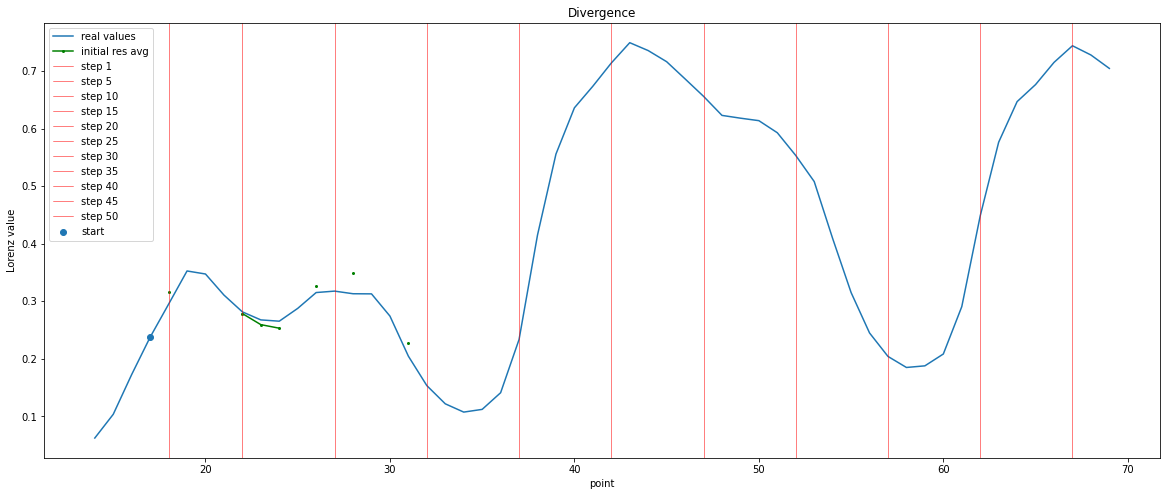

In [144]:
visualize_point([(init_demon, 'initial res avg')], 
                17, 
                real_vals=x_test
                )

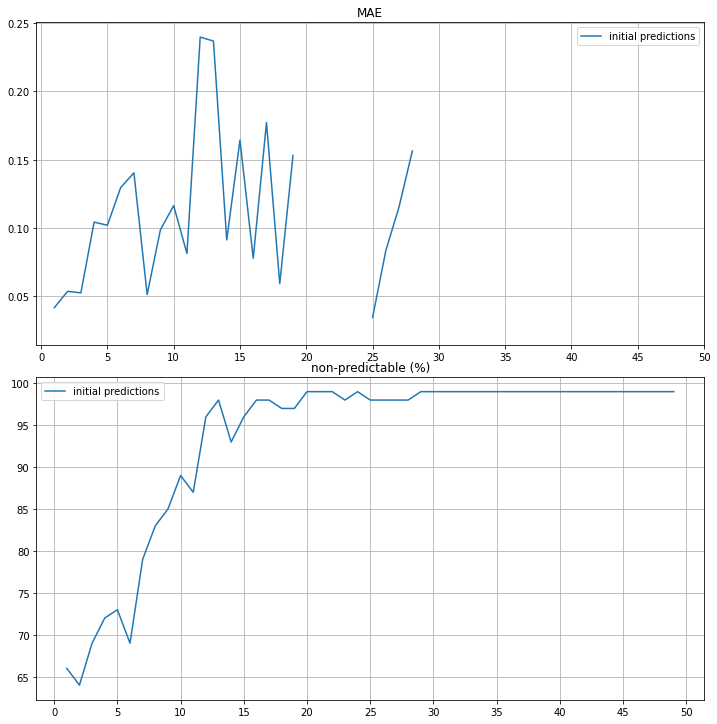

In [131]:
deamons = [(init_demon, "initial predictions")]
get_metrics(deamons, x_test)

In [ ]:
# generate_predictions(centers, deamon=Ideal_deamon_test, real_mode='test')

In [ ]:
# np.save('Ideal_deamon_test_pred.npy', Ideal_deamon_test.get_predictions())
# np.save('Ideal_deamon_test_set.npy', Ideal_deamon_test.get_set_predictions())

In [ ]:
# deamons = [(init_demon, 'initial res'), (Ideal_deamon_test, 'ideal deamon')]
# get_metrics(deamons, x_test)

In [ ]:
# init_demon_val_sf = MLDemon(clf=trained_clf, stats=all_stats, scaler=scaler)

In [ ]:
# generate_predictions(centers, deamon=init_demon_val_sf, real_mode='val_sf')

In [ ]:
# np.save('init_demon_val_pred.npy', init_demon_val_sf.get_predictions())
# np.save('init_demon_val_set.npy', init_demon_val_sf.get_set_predictions())

In [ ]:
# deamons = [(init_demon_val_sf, 'initial res')]
# get_metrics(deamons, x_val_sf)

# Self-filling подготовка

In [146]:
WINDOW = 14

In [147]:
def generate_patterns_for_self():
    self_patterns = generate_subsequences(WINDOW - 1, N - 1)
    return random.choices(self_patterns, k=100)

In [148]:
self_patterns = generate_patterns_for_self()

In [149]:
x_trains = {}

for pattern in self_patterns:
    key = str_subseq(pattern + (WINDOW - 1,))
    x_trains[key] = generate_sample(x_train, WINDOW, pattern, put_none=False)

In [150]:
%%time

self_centers = generate_centers(x_trains)

CPU times: user 23min 47s, sys: 5.49 s, total: 23min 53s
Wall time: 23min 51s


In [151]:
np.save("drive/My Drive/irka/real/self_centers_real.npy", self_centers)

# Self-filling функции

### Переменные

In [153]:
WINDOW = 14

In [208]:
best_classifiers = [(LogisticRegression(C=1), 'logreg'),
                    (SVC(C=1, kernel='poly'), 'svm'),
                    (DecisionTreeClassifier(), 'decision tree'),
                    (KNeighborsClassifier(n_neighbors=3, weights='distance'), 'knn'),
                    (MLPClassifier(activation='logistic', hidden_layer_sizes=(128, 64, 32, 16)),
                      'mlp')]

### Классы алгоритма Self-filling

#### "Простой" self-filling без определения непрогнозируемых точек  

In [155]:
class SelfDemonSimple(object):
    def __init__(self):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = val
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'dist', self.set_predictions)
        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

#### "Идеальный" self-filling, сравнивающий прогноз с истинным значением

In [156]:
class SelfDeamonIdeal(object):
    def __init__(self, eps=0.05, mode='simple', real_vals=x_test):
        self.eps = eps
        self.real_vals=real_vals
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        pred, _, _ = get_weights(start_point, step, 'dist', self.set_predictions)

        if not pred or abs(pred - self.real_vals[start_point + step]) > self.eps:
            pred = val

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
       return self.predictions
    
    def get_set_predictions(self):
       return self.set_predictions

    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

#### Self-filling, использующий МО для определения непрогнозируемых точек

In [157]:
class SelfDemon(object):
    def __init__(self, clf, stats, scaler, ensemble=False):
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.clf = clf
        self.stats = stats
        self.scaler = scaler
        self.ensemble = ensemble
        
    @property
    def label(self):
        return self.stat.label()

    def predict(self, start_point, step, preds, val):
        self.set_predictions[start_point].append(preds)
        if not preds:
            pred = val
            self.predictions[start_point].append(pred)
            return pred
        
        pred, preds, weights = get_weights(start_point, step, 'dist', self.set_predictions)
        hist_vals = np.histogram(preds, weights=weights, bins=100, range=(0, 1)) 

        features = []
        for stat in self.stats:
            features.append(stat.apply(preds, hist_vals))
        
        features = self.scaler.transform([features])
        
        if self.ensemble:
            votes = self.clf.predict(features)

            if np.mean(votes) <= 0.5:
                pred = val
                self.predictions[start_point].append(pred)
                return pred
        else:
            if not self.clf.predict(features):
                pred = val
                self.predictions[start_point].append(pred)
                return pred

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    # def reset(self):
    #     self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
    #     self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}


    def set_preds(self, preds):
        self.predictions = preds
        return 

    def set_preds_set(self, preds):
        self.set_predictions = preds
        return

### Функции

#### Подстановка паттерна с позицией точки

In [158]:
def gen_sample_in_point_sf(values, window, pattern, pos, i): #change
    if i == N - 1 or pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = False

        if i != N - 1:
            bad = values[pos] == None

        for j in range(len(pattern)):
            val = values[pos - window + 1 + pattern[j]]
            if val == None and i != j:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        
        vals.append(values[pos])
        return vals
    else:
        return None

#### Функция предсказания 

In [159]:
from tqdm import trange, tqdm

def generate_predictions_sf(sf_centers, demon, self_demon, return_set_pred=False, all=False, extend=False, last_p=False, real_mode='test',
                          EPS=0.05, Q_VALUE=0.99):

    start_p_preds = {}
    start_p_set_preds = {}

    #mycomm: тестовая
    if real_mode == 'test':
        end_point = val_sf_end 
        init_point = test_init
    
    #mycomm: валидационная
    else:
        end_point = val_end 
        init_point = val_sf_init

    patterns_tmp = list(map(lambda x: tuple(list(map(lambda y: int(y), x.split(',')[:-1]))), list(sf_centers.keys())))  

    for start_point in tqdm(range(1, PTS)): 

        # initialize empty
        start_p_preds[start_point] = [None] * (start_point + 1) 
        if return_set_pred:
            start_p_set_preds[start_point] = [None] * (start_point + 1)

        
        data = demon.get_predictions()[start_point][start_point + 1:]
      
        # проходимся по ряду
        for step in range(1, STEPS + 1):
            possible_vals = []
            if extend:
                possible_vals = demon.get_set_predictions()[start_point][start_point + step]
            
            if data and (data[step - 1] is None) or (all and step > WINDOW):
                    
                # проходимся по позициям в паттерне 
                for i in range(N - 1):            
                    x_tests_for_point = {}
                    
                    # проходимя по паттернам  
                    for pattern in patterns_tmp:    
                        key = str_subseq(pattern + (WINDOW - 1,))
                        x_tests_for_point[key] = None

                        start_w = step - 1 - pattern[i]

                        if start_w >= 0:
                          wind = data[start_w : start_w + WINDOW]
                          sample = gen_sample_in_point_sf(wind, WINDOW, pattern, len(wind) - 1, i) 
                          
                          if sample:
                              x_tests_for_point[key] = sample

          
                    chosen_centers = []
                    for pattern, centers_values in sf_centers.items():

                        if not x_tests_for_point[pattern] is None:
                            vector = np.array(x_tests_for_point[pattern][:i] + x_tests_for_point[pattern][i + 1:])

                            for center in centers_values:
                                dist = euclidean(vector, np.hstack((center[:i], center[i + 1:])))
                                if dist < EPS:
                                    weight_d = (EPS - dist) / EPS
                                    chosen_centers.append((pattern, center, weight_d))


                            possible_vals += list(map(lambda center: (center[1][i], center[2], center[0]), 
                                                  chosen_centers)) #mycomm: (i-е значение, d, паттерн)

                if last_p:
                    for pattern in patterns_tmp:
                        key = str_subseq(pattern + (WINDOW - 1,)) 
                        start_w = step - WINDOW
                        # print(step, start_w)

                        if start_w >= 0:
                              wind = data[start_w : start_w + WINDOW]

                        # print(wind)
                        sample = gen_sample_in_point_sf(wind, WINDOW, pattern, len(wind) - 1, N-1)
                        
                        if not sample:
                            x_tests_for_point[key] = None
                        else:
                            x_tests_for_point[key] = sample
                            # print(sample[-1])

                    chosen_centers = []
                    for pattern, centers_values in sf_centers.items():

                        if not x_tests_for_point[pattern] is None:
                            vector = np.array(x_tests_for_point[pattern][:-1])

                            for center in centers_values:
                                dist = euclidean(vector, center[:-1])
                                if dist < EPS:
                                    weight_d = (EPS - dist) / EPS
                                    chosen_centers.append((pattern, center, weight_d))


                            possible_vals += list(map(lambda center: (center[1][-1], center[2], center[0]), 
                                                  chosen_centers)) #mycomm: (i-е значение, d, паттерн)
                                  


            result_point = self_demon.predict(start_point, step, possible_vals, data[step - 1])
            
            start_p_preds[start_point].append(result_point)

            if return_set_pred:
                start_p_set_preds[start_point].append(possible_vals)

    if return_set_pred:
        return start_p_preds, start_p_set_preds

    return start_p_preds

#### Применение и скачивание self-filling

In [160]:
def load_sf_ml(X, y, n, clf, stats, scaler, path, ex=False):
  sf = []

  clf.fit(X, y)

  for i in range(n):
      sf.append(SelfDemon(clf, lin_stats, lin_scaler))
      f_name_pred = path + '_pred' + str(i + 1)
      f_name_set = path + '_set' + str(i + 1)

      if ex:
        f_name_pred += '_ex'
        f_name_set += '_ex'

      f_name_pred += '.npy'
      f_name_set += '.npy'

      preds = np.load(f_name_pred, allow_pickle=True).item()
      #preds_set = np.load(f_name_set, allow_pickle=True).item()
      sf[i].set_preds(preds)
      #sf[i].set_preds_set(preds_set)
  return sf

In [161]:
def apply_sf_ml(X, y, n, clf, stats, scaler, init=init_demon, all=False, extend=False, eps=0.05, last_p=False, self_centers=self_centers):
  sf = []

  clf.fit(X, y)

  for i in range(n):
      sf.append(SelfDemon(clf, stats, scaler))

  generate_predictions_sf(self_centers, init, sf[0], all=all, extend=extend, last_p=True)

  for i in range(len(sf) - 1):
    generate_predictions_sf(self_centers, sf[i], sf[i + 1], all=all, extend=extend, EPS=eps, last_p=last_p)

  return sf

# Результаты self-filling

In [209]:
sf_lin = apply_sf_ml(X_lin, y_lin, 15, best_classifiers[0][0], lin_stats, lin_scaler, all=False, extend=False, last_p=True)

100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


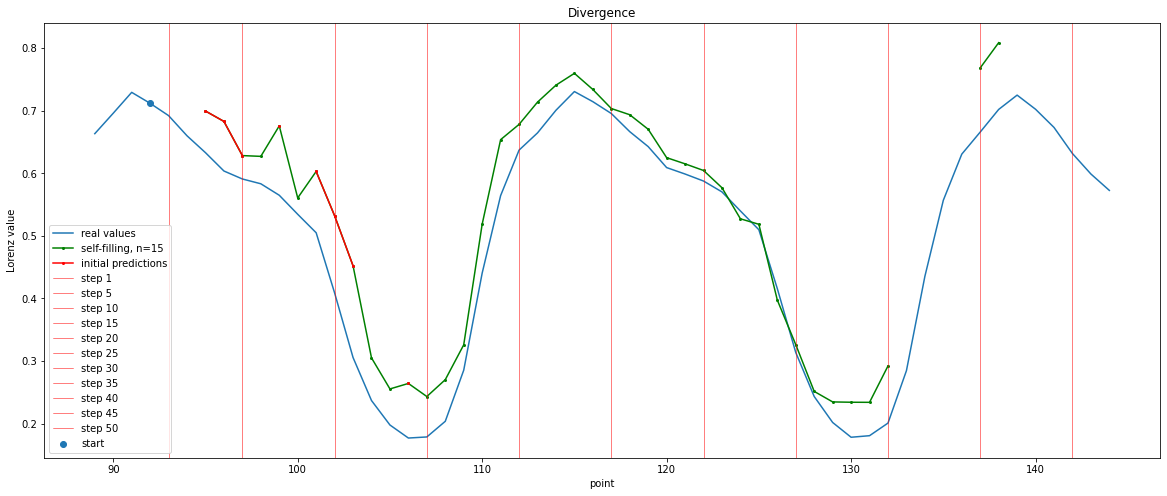

In [211]:
visualize_point([(sf_lin[-1], 'self-filling, n=15'), (init_demon, 'initial predictions')], 
                92, 
                real_vals=x_test
                )

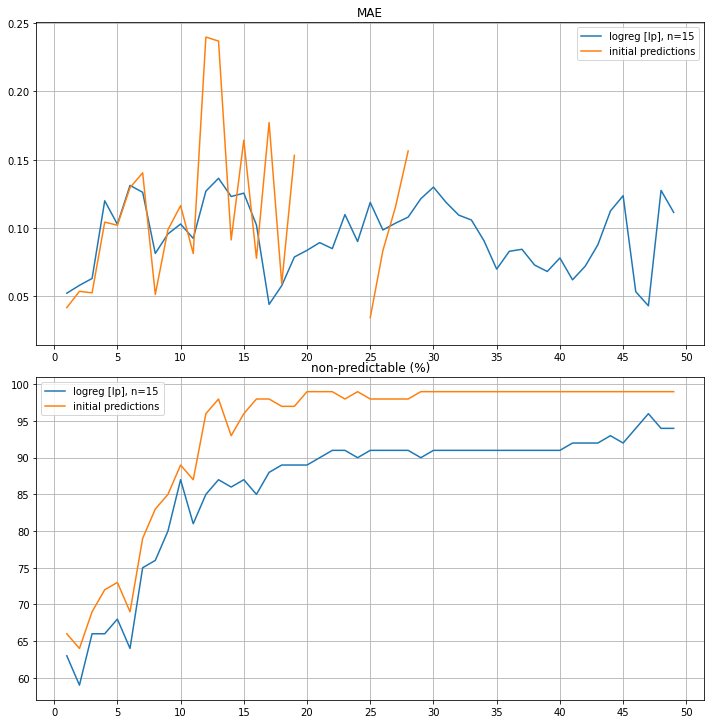

In [212]:
deamons = [(sf_lin[14], 'logreg [lp], n=15'),
           (init_demon, "initial predictions")
]
get_metrics(deamons, x_test)